# **Introductory note**

In this notebook, we will explore the fundamental concepts and computational methods for pricing European and American options. We will:

- Review the basic definition of derivatives and options.
- Distinguish European vs. American exercise features.
- Derive the Black–Scholes–Merton (BSM) formula and discuss its assumptions.
- Implement the BSM closed-form solution and a Monte Carlo (MC) approach for European options.
- Transition to American option pricing via binomial trees, finite-difference methods, and least-squares Monte Carlo.
- Compare the accuracy, complexity, and real-world considerations of these methods.

---

## 1. Define a derivative and an option

A **derivative** is a financial contract whose value depends on the performance of an underlying asset (e.g., a stock, index, commodity). An **option** is a particular type of derivative that grants its holder the right, but not the obligation, to buy (call option) or sell (put option) the underlying asset at a specified strike price $K$ by (or on) a specified expiration date $T$.

**Key terms**:

- **Underlying price** $S_t$: The price of the stock (or underlying asset) at time $t$.
- **Strike price** $K$: The agreed-upon price for the transaction if the option is exercised.
- **Expiration/maturity** $T$: The last date the option can be exercised.
- **Payoff**: The value the option holder would receive at exercise. For a vanilla (plain-vanilla) call, payoff at maturity is $\max(S_T - K, 0)$; for a put, $\max(K - S_T, 0)$.

---

## 2. Define European vs. American options

- **European options** can only be exercised at the maturity $T$. The holder waits until the final date to decide whether to exercise the option or let it expire worthless.

- **American options** can be exercised at any time up to and including maturity. This flexibility can be valuable, especially for puts when early exercise might be optimal if the stock price drops significantly.

**Key contractual differences**:

- **Exercise style**: European (only at $T$) vs. American (any time $0 \le t \le T$).
- **Early-exercise premium**: American options can have extra value because they permit early exercise, which may be optimal in certain scenarios (e.g., deep in-the-money puts when no dividends are paid).
- **Valuation**: European options can often be priced by a closed-form formula (like Black–Scholes–Merton), whereas American options typically require numerical methods (trees, finite differences, or Monte Carlo with optimal stopping).

---

## 3. Simple payoff diagram for a vanilla call and put

Below is a simple payoff diagram at expiration comparing a vanilla call and a vanilla put with strike price $K$. The call payoff is $\max(S_T - K, 0)$; the put payoff is $\max(K - S_T, 0)$.

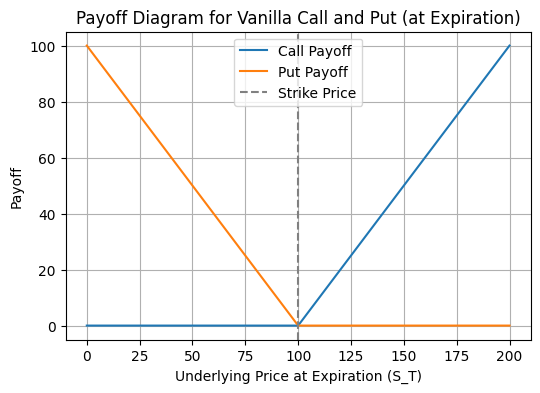

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the payoff diagram
S = np.linspace(0, 2*100, 200)  # underlying prices
K = 100

call_payoff = np.maximum(S - K, 0)
put_payoff = np.maximum(K - S, 0)

plt.figure(figsize=(6,4))
plt.plot(S, call_payoff, label='Call Payoff')
plt.plot(S, put_payoff, label='Put Payoff')
plt.axvline(K, color='gray', linestyle='--', label='Strike Price')
plt.title('Payoff Diagram for Vanilla Call and Put (at Expiration)')
plt.xlabel('Underlying Price at Expiration (S_T)')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()


You can see that the call option’s payoff becomes positive when $S_T > K$, whereas the put option’s payoff becomes positive when $S_T < K$.

---

## 4. European option pricing

### 4.1 Black–Scholes–Merton formula

The cornerstone of modern option pricing is the Black–Scholes–Merton (BSM) equation. For a European call option $C(t,S)$, the BSM partial differential equation (PDE) can be written as:

$$
\frac{\partial C}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + r S \frac{\partial C}{\partial S} - r C = 0
$$

with terminal condition at $t=T$:

$$
C(T,S) = \max(S - K, 0).
$$

Solving this PDE under assumptions of:

- Geometric Brownian motion (GBM) for the underlying with constant volatility $\sigma$,
- A frictionless market with constant risk-free interest rate $r$,
- No dividends,
- And no arbitrage,

leads to the closed-form Black–Scholes–Merton formula for a European call:

$$
C_0 = S_0 \Phi(d_1) - K e^{-r T} \Phi(d_2),
$$

where

$$
d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2) T}{\sigma \sqrt{T}}, \quad d_2 = d_1 - \sigma \sqrt{T}.
$$

$\Phi(\cdot)$ is the cumulative distribution function (CDF) of the standard normal distribution.

For a European put, by put–call parity (or directly by solving the PDE), the price is:

$$
P_0 = K e^{-r T} \Phi(-d_2) - S_0 \Phi(-d_1).
$$

**Model assumptions**:

- The underlying $S_t$ follows a Geometric Brownian Motion: $dS_t = \mu S_t dt + \sigma S_t dW_t$.
- Market is frictionless (no transaction costs, continuous trading).
- Constant $r$ (risk-free rate) and $\sigma$ (volatility).
- No dividends paid by the underlying over $[0, T]$.
- The pricing is done under the risk-neutral measure, shifting the drift to $r$.

### 4.2 Python implementation of Black–Scholes–Merton

Below, we implement a clean, reusable Python function that computes the price of a European call or put via the BSM formula.

In [2]:
import numpy as np
from scipy.stats import norm

def black_scholes_price(S, K, r, sigma, T, option_type='call'):
    """
    Computes the Black-Scholes price for a European call or put option.

    Parameters
    ----------
    S : float
        Current underlying price
    K : float
        Strike price
    r : float
        Risk-free interest rate
    sigma : float
        Volatility (annualized)
    T : float
        Time to maturity (in years)
    option_type : str
        'call' or 'put'

    Returns
    -------
    float
        Theoretical option price by Black–Scholes–Merton formula.
    """
    if T <= 0:
        # At or past maturity, option value = payoff
        if option_type.lower() == 'call':
            return max(S - K, 0)
        else:
            return max(K - S, 0)
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    return price

# Quick example usage
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0

call_price = black_scholes_price(S0, K, r, sigma, T, 'call')
put_price  = black_scholes_price(S0, K, r, sigma, T, 'put')

print(f"European Call Price (BSM): {call_price:.4f}")
print(f"European Put Price  (BSM): {put_price:.4f}")


European Call Price (BSM): 10.4506
European Put Price  (BSM): 5.5735


Another way to price a European option is to simulate the distribution of the underlying at maturity under the risk-neutral measure. The steps:

1.  Generate sample paths of $S_t$ from $t=0$ to $T$ under the risk-neutral drift $r$.

Specifically, for each small time increment $\Delta t$, we generate the underlying asset price using the exact solution to the SDE under the risk-neutral measure:

$$
S_{t+\Delta t} = S_t \exp\left( \left(r - \frac{1}{2} \sigma^2\right) \Delta t + \sigma \sqrt{\Delta t} Z \right),
$$

where $Z \sim N(0, 1)$ is a standard normal random variable, drawn independently for each step and each path. By repeating this step for $t=0, \Delta t, 2\Delta t, \dots, T-\Delta t$, we obtain a full simulated path of $S_t$ from $t=0$ to $T$. For pricing standard European options, we often only need the terminal value $S_T$, which can be simulated directly without generating the intermediate steps:

$$
S_{T} = S_0 \exp\left( \left(r - \frac{1}{2} \sigma^2\right) T + \sigma \sqrt{T} Z \right).
$$
2.  Compute the terminal payoff $\max(S_T - K, 0)$ (if call) or $\max(K - S_T, 0)$ (if put).
3.  Take the average of the discounted payoffs, $\exp(-rT) \cdot \text{mean}(\text{payoffs})$, as the Monte Carlo price estimate.
The law of large numbers ensures convergence; we can also use variance reduction (antithetic variates, control variates, etc.), but we will first implement the plain approach.

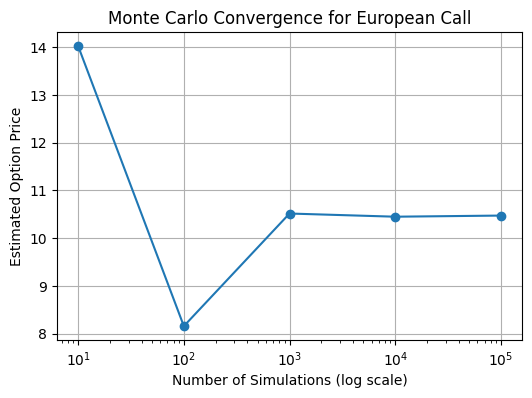

Number of sims | MC Estimated Call Price
             10 | 14.0205
            100 | 8.1600
           1000 | 10.5166
          10000 | 10.4502
         100000 | 10.4739


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def euro_vanilla_mc(S, K, r, sigma, T, n_sims=10000, option_type='call', seed=42):
    """
    Monte Carlo pricing for a European call/put using plain (naive) simulation.

    Parameters
    ----------
    S : float
        Current underlying price
    K : float
        Strike price
    r : float
        Risk-free interest rate
    sigma : float
        Volatility
    T : float
        Time to maturity
    n_sims : int
        Number of Monte Carlo simulations
    option_type : str
        'call' or 'put'
    seed : int
        Random seed for reproducibility
    
    Returns
    -------
    float
        Monte Carlo estimate of the option price
    """
    np.random.seed(seed)
    
    # Generate terminal underlying prices under the risk-neutral measure
    # S_T = S_0 * exp((r - 0.5*sigma^2)*T + sigma*sqrt(T)*Z)
    Z = np.random.randn(n_sims)
    S_T = S * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)

    if option_type.lower() == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:
        payoffs = np.maximum(K - S_T, 0)
    
    # Discounted average payoff
    price_mc = np.exp(-r*T) * np.mean(payoffs)
    return price_mc

# Illustrate convergence
ns = [10, 100, 1_000, 10_000, 100_000]
call_estimates = [euro_vanilla_mc(S0, K, r, sigma, T, n_sims=n, option_type='call') for n in ns]

plt.figure(figsize=(6,4))
plt.plot(ns, call_estimates, marker='o')
plt.xscale('log')
plt.title('Monte Carlo Convergence for European Call')
plt.xlabel('Number of Simulations (log scale)')
plt.ylabel('Estimated Option Price')
plt.grid(True)
plt.show()

print("Number of sims | MC Estimated Call Price")
for n, est in zip(ns, call_estimates):
    print(f"{n:15d} | {est:.4f}")


**Interpretation**: As the number of simulations $M$ grows, the estimated price converges to the true (BSM) value due to the Law of Large Numbers. The error typically decreases proportionally to $1/\sqrt{M}$.

#### 4.3.3 Sample simulated price paths

Although for pricing a simple European option using Monte Carlo we only need the terminal prices $S_T$, simulating the intermediate steps can be useful for visualizing the underlying process or for pricing path-dependent options. Below we plot a small sample of simulated paths for illustrative purposes.

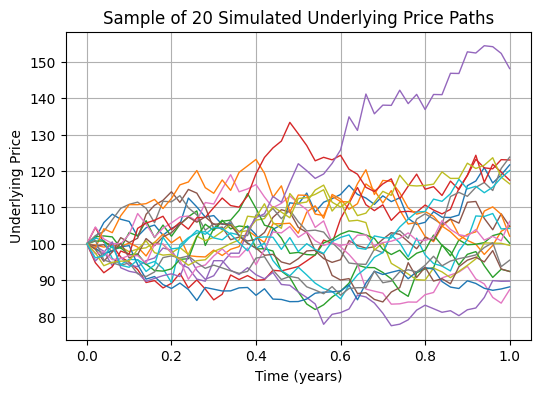

In [4]:
def simulate_price_paths(S, r, sigma, T, steps=50, n_paths=20, seed=42):
    np.random.seed(seed)
    dt = T / steps
    paths = np.zeros((steps+1, n_paths))
    paths[0,:] = S
    for i in range(1, steps+1):
        Z = np.random.randn(n_paths)
        paths[i,:] = paths[i-1,:] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    return paths

paths = simulate_price_paths(S0, r, sigma, T, steps=50, n_paths=20)
time_grid = np.linspace(0, T, paths.shape[0])

plt.figure(figsize=(6,4))
for j in range(paths.shape[1]):
    plt.plot(time_grid, paths[:,j], lw=1)
plt.title('Sample of 20 Simulated Underlying Price Paths')
plt.xlabel('Time (years)')
plt.ylabel('Underlying Price')
plt.grid(True)
plt.show()


## 6. American option pricing

European options have a neat closed-form solution (BSM) or can be priced relatively easily with standard Monte Carlo. However, American options, with their early exercise feature, typically require more advanced numerical techniques because we need to determine the optimal exercise strategy at each possible time $t < T$. We will explore three common methods:

-   **Binomial Tree (Cox-Ross-Rubinstein Model)**
-   **Finite Difference Methods**
-   **Least-Squares Monte Carlo (Longstaff-Schwartz)**

### 6.1 Binomial Tree (Cox-Ross-Rubinstein Model)

The Cox–Ross–Rubinstein (CRR) binomial tree is a popular discrete-time model that approximates the Geometric Brownian Motion process.

-   **Time Discretization**: Divide the time interval $[0, T]$ into $N$ small steps of equal length $\Delta t = T/N$.
-   **Price Movement**: At each step, assume the underlying asset price $S$ can only move to one of two possible values:
    -   "Up" move to $S \cdot u$, where the up factor is $u = e^{\sigma \sqrt{\Delta t}}$.
    -   "Down" move to $S \cdot d$, where the down factor is $d = e^{-\sigma \sqrt{\Delta t}} = 1/u$.
-   **Risk-Neutral Probability**: The probability of an "up" move in a risk-neutral world is calculated as $p = \frac{e^{(r-q)\Delta t} - d}{u - d}$ (where $q$ is the continuous dividend yield, assumed 0 if not specified). The probability of a down move is $1-p$.
-   **Valuation Process**:
    1.  **Build Price Tree**: Construct the tree of possible underlying asset prices forward in time from $t=0$ to $t=T$.
    2.  **Terminal Values**: Calculate the option's intrinsic value at each final node at maturity $T$ (e.g., $\max(S_T - K, 0)$ for a call).
    3.  **Backward Induction**: Work backward through the tree from $t=T-\Delta t$ to $t=0$. At each node $(i, j)$ (time step $i$, state $j$):
        -   Calculate the *continuation value*: The expected discounted value if the option is held, computed using the values at the next step ($i+1$) and the risk-neutral probabilities: $e^{-r \Delta t} [p V_{i+1, j+1} + (1-p) V_{i+1, j}]$.
        -   Calculate the *exercise value*: The value if exercised immediately at that node (e.g., $\max(S_{ij} - K, 0)$ for a call or $\max(K - S_{ij}, 0)$ for a put).
        -   For an **American option**, the value at node $(i, j)$ is $V_{ij} = \max(\text{exercise value, continuation value})$.
        -   For a **European option**, the value is simply the continuation value (as exercise is only allowed at $T$).
    4.  **Initial Price**: The option price at $t=0$ is the value $V_{00}$ at the root node of the tree.

In [15]:
def american_binomial_price(S, K, r, sigma, T, steps=100, option_type='call'):
    """
    Binomial model for American option pricing (Cox-Ross-Rubinstein).
    
    Parameters
    ----------
    S : float
        Current underlying price
    K : float
        Strike price
    r : float
        Risk-free interest rate
    sigma : float
        Volatility
    T : float
        Time to maturity
    steps : int
        Number of binomial steps
    option_type : str
        'call' or 'put'
    
    Returns
    -------
    float
        Estimated American option price
    """
    import math
    
    dt = T / steps
    u = math.exp(sigma * math.sqrt(dt))
    d = 1/u
    p = (math.exp(r*dt) - d) / (u - d)
    discount = math.exp(-r*dt)
    
    # Initialize asset prices at maturity
    prices = np.zeros(steps+1)
    prices[0] = S * d**steps
    for i in range(1, steps+1):
        prices[i] = prices[i-1] * (u/d)
    
    # Initialize option values at maturity
    option_values = np.zeros(steps+1)
    if option_type.lower() == 'call':
        option_values = np.maximum(prices - K, 0)
    else:
        option_values = np.maximum(K - prices, 0)
    
    # Backward induction
    for j in range(steps-1, -1, -1):
        for i in range(j+1):
            # Option value if we continue
            continuation_value = discount * (p*option_values[i+1] + (1-p)*option_values[i])
            # Underlying price at node
            S_ij = S * (u**i) * (d**(j-i))
            # Immediate exercise value
            if option_type.lower() == 'call':
                exercise_value = max(S_ij - K, 0)
            else:
                exercise_value = max(K - S_ij, 0)
            
            option_values[i] = max(exercise_value, continuation_value)
    
    return option_values[0]

# Example usage
am_call_price = american_binomial_price(S0, K, r, sigma, T, steps=100, option_type='call')
am_put_price  = american_binomial_price(S0, K, r, sigma, T, steps=100, option_type='put')

print(f"American Call Price (Binomial, 100 steps): {am_call_price:.4f}")
print(f"American Put  Price (Binomial, 100 steps): {am_put_price:.4f}")


American Call Price (Binomial, 100 steps): 10.4306
American Put  Price (Binomial, 100 steps): 6.0824


**Interpretation**: The numerical results typically show that the American call price (on an underlying asset that pays no dividends) is often equal or very close to the corresponding European call price (calculated via BSM). This is because it's generally not optimal to exercise an American call early on a non-dividend-paying stock; holding the option preserves time value and optionality, and holding the cash K (that would be spent on exercise) earns the risk-free rate. Conversely, the American put price is usually higher than its European counterpart. Early exercise of an American put can be optimal, especially if the option is deep in-the-money (stock price is very low relative to K), as the holder receives the strike price K sooner, which can then earn interest, and avoids the risk of the stock price potentially recovering.

### 6.1.1 Lattice figure (3-step example)

We can illustrate a small (3-step) binomial tree for the underlying prices and highlight the early-exercise boundary for a put, for example:

/tmp/ipykernel_43147/2847832402.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


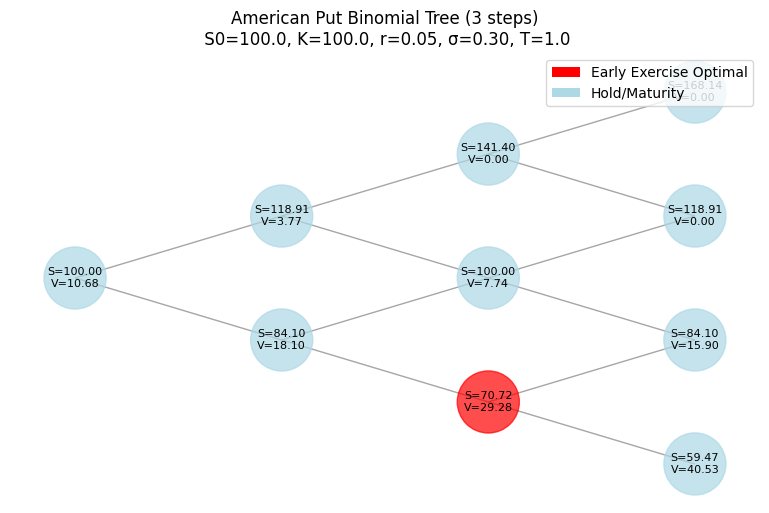

In [20]:
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt

def plot_american_put_tree(S, K, r, sigma, T, steps):
    """
    Calculates and plots the binomial tree for an American put option.

    Highlights nodes where early exercise is optimal.

    Parameters
    ----------
    S : float
        Current underlying price
    K : float
        Strike price
    r : float
        Risk-free interest rate (annualized)
    sigma : float
        Volatility (annualized)
    T : float
        Time to maturity (in years)
    steps : int
        Number of binomial steps (keep small for visualization, e.g., 3-5)
    """
    if steps > 10:
        print("Warning: Plotting large trees (>10 steps) can be slow and cluttered.")

    # --- Calculate Binomial Parameters ---
    dt = T / steps
    sqrt_dt = math.sqrt(dt)
    u = math.exp(sigma * sqrt_dt)
    d = 1.0 / u
    exp_rdt = math.exp(r * dt)
    p = (exp_rdt - d) / (u - d)
    discount = math.exp(-r * dt)

    if not (0 < p < 1):
         print(f"Warning: Risk-neutral probability p={p:.4f} is outside (0, 1).")
         # Clamping for robustness if proceeding
         p = max(0.0001, min(0.9999, p))


    # --- Initialize Trees to Store Values ---
    # Use dictionaries for sparse storage, keys are (step, node_index_from_bottom)
    S_tree = {}
    V_tree = {}
    exercise_tree = {} # Boolean flag: True if early exercise optimal

    # --- Step 1: Build Stock Price Tree (Forward) ---
    for i in range(steps + 1): # Time steps 0 to N
        for j in range(i + 1): # Nodes at step i (j = num up moves)
            node = (i, j)
            S_tree[node] = S * (u ** j) * (d ** (i - j))

    # --- Step 2: Calculate Option Values (Backward) ---
    # Maturity values (step N)
    i = steps
    for j in range(i + 1):
        node = (i, j)
        V_tree[node] = max(K - S_tree[node], 0)
        exercise_tree[node] = False # Cannot exercise early at maturity

    # Backward induction for steps N-1 down to 0
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            node = (i, j)
            node_up = (i + 1, j + 1)
            node_down = (i + 1, j)

            # Option value if held (continuation value)
            continuation_value = discount * (p * V_tree[node_up] + (1 - p) * V_tree[node_down])

            # Immediate exercise value at node (i, j)
            exercise_value = max(K - S_tree[node], 0)

            # American option value
            V_tree[node] = max(exercise_value, continuation_value)

            # Determine if early exercise is optimal (strictly better)
            # Use a small tolerance to handle potential floating point inaccuracies
            if exercise_value > continuation_value + 1e-9: # Added tolerance
                 exercise_tree[node] = True
            else:
                 exercise_tree[node] = False

    # --- Step 3: Create Visualization using NetworkX ---
    G = nx.Graph() # Use Graph for simpler plotting layout
    pos = {}
    labels = {}
    node_colors = []

    for i in range(steps + 1):
        for j in range(i + 1):
            node = (i, j)
            # Position: i = x-coord, center vertically based on j
            pos[node] = (i, 2*j - i)
            labels[node] = f"S={S_tree[node]:.2f}\nV={V_tree[node]:.2f}"
            if i < steps and exercise_tree[node]: # Highlight early exercise nodes (not maturity)
                 node_colors.append('red')
            else:
                 node_colors.append('lightblue')

            # Add edges from this node to the next step nodes
            if i < steps:
                G.add_edge(node, (i + 1, j))     # Down move edge
                G.add_edge(node, (i + 1, j + 1)) # Up move edge


    # Draw the graph
    plt.figure(figsize=(max(6, steps * 2.5), max(4, steps * 1.5))) # Adjust size
    nx.draw(G, pos, node_color=node_colors, node_size=2000, with_labels=False, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    # Add a simple legend/title
    red_patch = plt.Rectangle((0,0), 1, 1, fc="red") # dummy object for legend
    blue_patch = plt.Rectangle((0,0), 1, 1, fc="lightblue") # dummy object for legend
    plt.legend([red_patch, blue_patch], ["Early Exercise Optimal", "Hold/Maturity"], loc='upper right')
    plt.title(f'American Put Binomial Tree ({steps} steps)\n S0={S:.1f}, K={K:.1f}, r={r:.2f}, σ={sigma:.2f}, T={T:.1f}')
    plt.axis('off') # Hide the axes
    plt.tight_layout()
    plt.show()


# --- Example Usage ---
S0 = 100.0
K = 100.0
r = 0.05
sigma = 0.30 # Increased volatility to make early exercise more likely
T = 1.0
N_steps = 3 # Keep small for clarity

plot_american_put_tree(S0, K, r, sigma, T, N_steps)

# Example 2: Deeper in-the-money put
# S0_2 = 90.0
# K_2 = 100.0
# r_2 = 0.05
# sigma_2 = 0.25
# T_2 = 0.5
# N_steps_2 = 4
# plot_american_put_tree(S0_2, K_2, r_2, sigma_2, T_2, N_steps_2)

**Interpretation**: Each node denotes the underlying price at that step. In an American put, you would compare the immediate exercise value ($\max(K-S, 0)$) vs. continuation value obtained by rolling back from future nodes.

---

## 7. Finite-difference method

For American options, the valuation problem can be formulated as solving a free-boundary Partial Differential Equation (PDE). The value $V(S, t)$ must satisfy the Black-Scholes-Merton PDE in the region where the option is held (continuation region), but it is constrained by the early exercise value (intrinsic value). This is often expressed as a linear complementarity problem or solved iteratively.

The conditions are:
$$
\begin{cases}
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V \le 0 \\
V(S, t) \ge \text{intrinsic value} \quad (\text{e.g., } \max(K-S, 0) \text{ for a put}) \\
\left( \frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V \right) \cdot \left( V(S, t) - \text{intrinsic value} \right) = 0
\end{cases}
$$
The last condition means that either the PDE holds as an equality (if $V > \text{intrinsic value}$) or the option value equals the intrinsic value (if the PDE term is negative, implying exercise is better).

In practice, numerical methods like finite differences discretize the PDE on a grid and solve backward in time. At each time step, the early exercise constraint $V(S_j, t_i) \ge \text{intrinsic value}(S_j)$ must be enforced.

We discretize in time and space (e.g., using a Crank–Nicolson scheme for time evolution, which averages implicit and explicit steps for stability and accuracy) and solve the resulting system, often by an iterative method like PSOR (Projected Successive Over-Relaxation) that incorporates the free-boundary constraint (the projection onto the intrinsic value).

Below is a conceptual outline for implementing a finite-difference solver for an American put:

1.  **Set up grids**:
    *   Define a spatial grid for the underlying price $S \in [0, S_{\max}]$, where $S_{\max}$ is a suitably large upper bound (e.g., 3-5 times K). Discretize into $N_S$ intervals, $\Delta S = S_{\max} / N_S$. Grid points are $S_j = j \Delta S$ for $j=0, \dots, N_S$.
    *   Define a time grid: Discretize the time interval $[0, T]$ into $N_t$ steps of size $\Delta t = T / N_t$. Grid points are $t_i = i \Delta t$ for $i=0, \dots, N_t$.
2.  **Boundary and Terminal Conditions**:
    *   **Terminal Condition**: At maturity $t=T$ (or $i=N_t$), the option value is its intrinsic value: $V(S_j, T) = \max(K - S_j, 0)$ for all $j$.
    *   **Boundary Conditions**:
        *   At $S=0$ ($j=0$): For a put, $V(0, t_i) = K e^{-r(T-t_i)}$.
        *   At $S=S_{\max}$ ($j=N_S$): For a put, $V(S_{\max}, t_i) = 0$ (assuming $S_{\max}$ is sufficiently large).
3.  **Discretize the PDE**: Replace partial derivatives with finite difference approximations. For example:
    *   $\frac{\partial V}{\partial t} \approx \frac{V_{j}^{i+1} - V_{j}^{i}}{\Delta t}$ (Backward difference for implicit, or use average for Crank-Nicolson)
    *   $\frac{\partial V}{\partial S} \approx \frac{V_{j+1}^{i} - V_{j-1}^{i}}{2 \Delta S}$ (Central difference)
    *   $\frac{\partial^2 V}{\partial S^2} \approx \frac{V_{j+1}^{i} - 2V_{j}^{i} + V_{j-1}^{i}}{(\Delta S)^2}$ (Central difference)
    (Here $V_j^i \approx V(S_j, t_i)$). The Crank-Nicolson scheme averages the spatial derivatives at time $t_i$ and $t_{i+1}$.
4.  **Backward Iteration (Time Stepping)**: Start from the known values at $t=T$ ($i=N_t$) and step backward to $t=0$ ($i=0$). For each time step from $i=N_t-1$ down to $0$:
    *   Set up the system of linear equations based on the chosen scheme (e.g., Implicit or Crank-Nicolson). For Crank-Nicolson, it looks like $A \mathbf{V}^{i} = B \mathbf{V}^{i+1} + \mathbf{c}$, where $\mathbf{V}^i$ is the vector of unknown option values at time $t_i$.
    *   Solve the system for the candidate values $\mathbf{V}^{*i}$.
    *   **Apply American Constraint**: For each grid point $j$, enforce the early exercise condition: $V_j^i = \max(V_j^{*i}, \max(K - S_j, 0))$. Iterative solvers like PSOR naturally incorporate this projection step.
5.  **Result**: The option price at $t=0$ for the initial stock price $S_0$ is found by interpolating the value $V(S_0, 0)$ from the grid values $V_j^0$ at $i=0$.

*(Implementation details, especially the matrix setup and solving with projection for the American constraint, require careful handling.)*

In [22]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import warnings

def american_put_fdm_cn_psor(S0, K, r, sigma, T, Ns, Nt, Smax_ratio=3, omega=1.4, tol=1e-6, max_iter=2000):
    """
    Prices an American put option using Finite Differences (Crank-Nicolson)
    with Projected Successive Over-Relaxation (PSOR).

    Parameters
    ----------
    S0 : float
        Initial stock price.
    K : float
        Strike price.
    r : float
        Risk-free interest rate (annualized).
    sigma : float
        Volatility (annualized).
    T : float
        Time to maturity (in years).
    Ns : int
        Number of steps in the stock price grid (excluding S=0). Total points = Ns+1.
    Nt : int
        Number of steps in the time grid.
    Smax_ratio : float, optional
        Ratio Smax/K to determine the upper boundary of the stock price grid. Default is 3.
    omega : float, optional
        SOR relaxation parameter (typically 1 < omega < 2). Default is 1.4.
    tol : float, optional
        Tolerance for SOR convergence. Default is 1e-6.
    max_iter : int, optional
        Maximum number of SOR iterations per time step. Default is 2000.

    Returns
    -------
    float
        Estimated American put option price at S0, t=0.
    """
    if S0 <= 0 or K <= 0 or sigma <= 0 or T <= 0:
        warnings.warn("Inputs S0, K, sigma, T should be positive.")
    if Ns <= 2 or Nt <= 1:
        raise ValueError("Ns must be > 2 and Nt must be > 1.")
    if not (1 < omega < 2):
        warnings.warn(f"omega = {omega} is outside the typical range (1, 2).")

    # --- Grid Setup ---
    Smax = K * Smax_ratio
    dS = Smax / Ns
    dt = T / Nt

    # Stock price grid (Ns+1 points from 0 to Smax)
    S_vec = np.linspace(0, Smax, Ns + 1)
    # Interior stock price grid points (Ns-1 points)
    S_int_vec = S_vec[1:-1]

    # Time grid (Nt+1 points from 0 to T) - we step backwards from T
    # Tau grid (time-to-maturity) might be conceptually simpler (tau = T-t)
    # Let's stick to backward time t for now

    # Initialize option value grid (vector)
    V = np.maximum(K - S_vec, 0) # Payoff at maturity T

    # --- Set up Crank-Nicolson coefficients (constant for this PDE) ---
    # These are coefficients for the spatial derivatives discretized
    j = np.arange(1, Ns) # Interior indices
    sigma2 = sigma**2
    aj = 0.5 * dt * (r * j - 0.5 * sigma2 * j**2)
    bj = 1 + dt * (r + sigma2 * j**2)
    cj = -0.5 * dt * (r * j + 0.5 * sigma2 * j**2)

    # Matrix for implicit part (LHS when solving for V^{n} from V^{n+1})
    # A V^{n} = B V^{n+1} + Boundary Terms --> We solve V^{n} iteratively
    # Let's formulate the iteration for V^{n} based on V^{n+1}
    # V_j^n - 0.5*dt*L(V_j^n) = V_j^{n+1} + 0.5*dt*L(V_j^{n+1})
    # Where L(V) = 0.5*sigma^2*S^2*V_SS + r*S*V_S - r*V
    # Coefficients for the iterative solver matrix (implicit part)
    # Diagonals correspond to terms multiplying V_j^n in the implicit part
    alpha = -0.25 * dt * (sigma2 * j**2 - r * j)
    beta = 1 + 0.5 * dt * (sigma2 * j**2 + r)
    gamma = -0.25 * dt * (sigma2 * j**2 + r * j)

    # --- Backward Time Iteration ---
    for n in range(Nt - 1, -1, -1): # Time steps from T-dt down to 0
        t = n * dt

        # Calculate the known RHS vector from V at step n+1
        # RHS = V^{n+1} + 0.5*dt*L(V^{n+1})
        # Explicit part coefficients:
        alpha_exp = 0.25 * dt * (sigma2 * j**2 - r * j)
        beta_exp = 1 - 0.5 * dt * (sigma2 * j**2 + r)
        gamma_exp = 0.25 * dt * (sigma2 * j**2 + r * j)

        rhs = alpha_exp * V[0:-2] + beta_exp * V[1:-1] + gamma_exp * V[2:]

        # Incorporate boundary conditions into RHS
        # Put boundary condition at S=0 (V[0])
        # V(0, t) = K * exp(-r*(T-t))
        # This affects the equation for j=1
        boundary_S0 = K * np.exp(-r * (T - t))
        rhs[0] += alpha[0] * boundary_S0 # From implicit part V_{0}^{n} term
        rhs[0] += alpha_exp[0] * boundary_S0 # From explicit part V_{0}^{n+1} term


        # Put boundary condition at S=Smax (V[Ns])
        # V(Smax, t) = 0
        # This affects the equation for j=Ns-1
        # rhs[Ns-2] += gamma[Ns-2] * 0 # Implicit part V_{Ns}^{n} term (which is 0)
        # rhs[Ns-2] += gamma_exp[Ns-2] * 0 # Explicit part V_{Ns}^{n+1} term (which is 0)

        # --- PSOR Iteration ---
        V_old_iter = V[1:-1].copy() # Values for interior points from previous time step
        payoff_int = np.maximum(K - S_int_vec, 0) # Payoff for interior points

        for k in range(max_iter):
            V_new_iter = V_old_iter.copy() # Start with previous iteration's values
            max_diff = 0.0

            # Update V[1] (j=1) using boundary V[0]
            val = (rhs[0] - (gamma[0] * V_old_iter[1])) / beta[0] # Implicit solve ignoring V[0] term moved to RHS
            V_new_iter[0] = max(payoff_int[0], V_old_iter[0] + omega * (val - V_old_iter[0]))
            max_diff = max(max_diff, abs(V_new_iter[0] - V_old_iter[0]))

            # Update interior points V[2] to V[Ns-2] (j=2 to Ns-2)
            for j_idx in range(1, Ns - 2): # Corresponds to j=2 to Ns-2
                 # Use already updated V_new_iter[j_idx-1]
                 val = (rhs[j_idx] - (alpha[j_idx] * V_new_iter[j_idx-1]) - (gamma[j_idx] * V_old_iter[j_idx+1])) / beta[j_idx]
                 V_new_iter[j_idx] = max(payoff_int[j_idx], V_old_iter[j_idx] + omega * (val - V_old_iter[j_idx]))
                 max_diff = max(max_diff, abs(V_new_iter[j_idx] - V_old_iter[j_idx]))

            # Update V[Ns-1] (j=Ns-1) using boundary V[Ns] = 0
            val = (rhs[Ns-2] - (alpha[Ns-2] * V_new_iter[Ns-3])) / beta[Ns-2] # Implicit solve ignoring V[Ns] term (0)
            V_new_iter[Ns-2] = max(payoff_int[Ns-2], V_old_iter[Ns-2] + omega * (val - V_old_iter[Ns-2]))
            max_diff = max(max_diff, abs(V_new_iter[Ns-2] - V_old_iter[Ns-2]))


            V_old_iter = V_new_iter # Prepare for next SOR iteration

            # Check convergence
            if max_diff < tol:
                break
        else: # No break encountered
             warnings.warn(f"PSOR did not converge at time step n={n} (t={t:.3f}) after {max_iter} iterations. Max diff: {max_diff:.2e}")


        # Update V for the current time step n
        V[1:-1] = V_old_iter # Store the converged values
        V[0] = boundary_S0 # Enforce boundary condition S=0
        V[Ns] = 0 # Enforce boundary condition S=Smax

    # --- Result ---
    # Interpolate the value at S0 from the final grid V (at t=0)
    option_price = np.interp(S0, S_vec, V)

    return option_price


# --- Example Usage ---
S0 = 100.0
K = 100.0
r = 0.05
sigma = 0.20
T = 1.0
Ns_fdm = 100   # Number of stock price steps
Nt_fdm = 100   # Number of time steps

# Calculate price using FDM
am_put_price_fdm = american_put_fdm_cn_psor(S0, K, r, sigma, T, Ns_fdm, Nt_fdm)
print(f"American Put Price (FDM CN-PSOR, Ns={Ns_fdm}, Nt={Nt_fdm}): {am_put_price_fdm:.4f}")

American Put Price (FDM CN-PSOR, Ns=100, Nt=100): 6.0997


---

## 8. Least-Squares Monte Carlo (LSMC)

An alternative simulation-based approach, particularly powerful for multi-asset or complex American (or Bermudan) options, is the Longstaff–Schwartz (Least-Squares) Monte Carlo (LSMC) algorithm. The core idea is to use regression on simulated paths to estimate the *continuation value* (the expected value of holding the option rather than exercising it) at each possible exercise time.

The algorithm proceeds as follows:

1.  **Simulate Paths**: Generate a large number $M$ of independent paths for the underlying asset(s) $S_t$ under the risk-neutral measure, usually discretized over the potential exercise dates $t_0=0, t_1, \dots, t_N=T$.
2.  **Backward Induction**: Start from the second-to-last exercise date ($t_{N-1}$) and work backward to $t_1$.
3.  **At each exercise date $t_i$ ($i = N-1, \dots, 1$)**:
    *   **Identify In-the-Money Paths**: Consider only the paths for which the option is in-the-money at time $t_i$ (i.e., immediate exercise value > 0). Let this subset of paths be $\mathcal{I}_i$.
    *   **Estimate Continuation Value**: For the paths in $\mathcal{I}_i$, regress the *realized, discounted cash flows* received from holding the option from $t_i$ onwards onto a set of basis functions of the underlying asset price $S_{t_i}$ at that time.
        *   The realized cash flow for a path $m \in \mathcal{I}_i$ is determined by the optimal exercise decisions already made for times $t_{i+1}, \dots, t_N$. Let this be $C(m, t_{i+1})$. The value used in the regression is $e^{-r(t_{i+1}-t_i)} C(m, t_{i+1})$.
        *   Common basis functions include polynomials of $S_{t_i}$ (e.g., $1, S_{t_i}, S_{t_i}^2, \dots$) or Laguerre polynomials.
        *   The regression yields a function $\hat{E}[\text{Continuation}| S_{t_i}]$ which estimates the expected continuation value conditional on the stock price at $t_i$.
    *   **Optimal Exercise Decision**: For each path $m \in \mathcal{I}_i$, compare the immediate exercise value $P(S_{t_i}^{(m)})$ with the estimated continuation value $\hat{E}[\text{Continuation}| S_{t_i}^{(m)}]$.
        *   If $P(S_{t_i}^{(m)}) > \hat{E}[\text{Continuation}| S_{t_i}^{(m)}]$, then the optimal decision for path $m$ at time $t_i$ is to exercise. Record the exercise payoff and stop considering cash flows from later times for this path.
        *   Otherwise, the decision is to hold (continue). The cash flow realized at $t_i$ is 0, and the cash flows from $t_{i+1}$ onwards remain relevant for regressions at earlier times $t_{j}$ ($j < i$).
4.  **Estimate Option Value**: After determining the optimal exercise strategy for all paths and all times $t_1, \dots, t_{N-1}$, the American option price at $t_0=0$ is estimated as the average of the discounted cash flows obtained along each path, following the derived optimal exercise rule. For each path $m$, find the first time $t_{i^*}$ where exercise occurred (or $t_N$ if never exercised early) and calculate $e^{-r t_{i^*}} P(S_{t_{i^*}}^{(m)})$. The LSMC estimate is the mean of these values over all $M$ paths.

Below, we implement a simple LSMC algorithm for an American put using polynomial basis functions and compare the result to our binomial reference price.

In [23]:
import numpy as np

def american_lsmc_price(S, K, r, sigma, T, steps=50, n_paths=10000, option_type='put', seed=42):
    """
    Least-Squares Monte Carlo (Longstaff–Schwartz) for American put or call.
    
    For demonstration, we use equally spaced exercise times and a simple polynomial basis.
    """
    np.random.seed(seed)
    dt = T / steps
    discount = np.exp(-r*dt)
    
    # Simulate underlying paths
    S_paths = np.zeros((steps+1, n_paths))
    S_paths[0,:] = S
    for t in range(1, steps+1):
        Z = np.random.randn(n_paths)
        S_paths[t,:] = S_paths[t-1,:] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    
    # Payoff function
    if option_type.lower() == 'put':
        payoff = lambda x: np.maximum(K - x, 0)
    else:
        payoff = lambda x: np.maximum(x - K, 0)
    
    # Cashflows array to store the realized payoff (if exercised)
    CF = np.zeros((steps+1, n_paths))
    # At maturity, exercise if in the money
    CF[steps,:] = payoff(S_paths[steps,:])
    
    # Work backward
    for t in range(steps-1, -1, -1):
        # In-the-money paths
        itm = payoff(S_paths[t,:]) > 0
        X = S_paths[t, itm]  # underlying in the money
        Y = CF[t+1:, itm]  # future cashflows if we never exercise now
        # Discount future cashflows back to time t
        # We take the max of time t+1 because t+2,... might not be exercised yet
        # but for LSMC we consider the immediate next exercise scenario
        discounted_future = np.zeros(X.shape[0])
        for i, path_idx in enumerate(np.where(itm)[0]):
            # find the next time s>t the option is exercised or matures
            # We look at CF[t+1..end, path_idx], discount them
            # In practice, we pick the first positive CF after t
            future_ex_idx = np.where(CF[t+1:, path_idx] > 0)[0]
            if len(future_ex_idx) > 0:
                first_ex = future_ex_idx[0]
                discounted_future[i] = CF[t+1+first_ex, path_idx] * discount**(first_ex+1)
            else:
                discounted_future[i] = 0
        
        # Regress discounted_future on polynomial basis of X (S[t])
        # simple polynomial basis: [1, X, X^2]
        A = np.vstack([np.ones(X.shape[0]), X, X**2]).T
        coeff, _, _, _ = np.linalg.lstsq(A, discounted_future, rcond=None)
        
        # Continuation value estimate
        continuation_value = coeff[0] + coeff[1]*X + coeff[2]*X**2
        
        # Exercise decision
        exercise_value = payoff(X)
        exercise_idx = (exercise_value > continuation_value)
        
        # For those who exercise, set CF at time t
        exercise_paths = np.where(itm)[0][exercise_idx]
        CF[t, exercise_paths] = exercise_value[exercise_idx]
        # For times t+1..end, set CF=0 if exercised
        for ep in exercise_paths:
            CF[t+1:, ep] = 0
    
    # The price is the average discounted payoff from t=0
    # If exercised at time t, payoff was CF[t], discounted from t to 0 => * exp(-r*t*dt)
    prices = np.zeros(n_paths)
    for path_idx in range(n_paths):
        ex_times = np.where(CF[:, path_idx]>0)[0]
        if len(ex_times) > 0:
            first_ex = ex_times[0]
            prices[path_idx] = CF[first_ex, path_idx]*np.exp(-r*(first_ex*dt))
        else:
            prices[path_idx] = 0
    
    return np.mean(prices)

# Compare LSMC with binomial for an American put
lsmc_price = american_lsmc_price(S0, K, r, sigma, T=1.0, steps=50, n_paths=10000, option_type='put')
binom_price = american_binomial_price(S0, K, r, sigma, T=1.0, steps=200, option_type='put')

print(f"American Put Price (LSMC):    {lsmc_price:.4f}")
print(f"American Put Price (Binomial): {binom_price:.4f}")


American Put Price (LSMC):    6.0959
American Put Price (Binomial): 6.0864


Interpretation: We should get results reasonably close (though not exact, depending on the number of paths, polynomial basis, etc.). This LSMC approach scales well to high-dimensional problems (e.g., multi-asset options).

**8.1 Histogram of discounted payoffs**
We can visualize the distribution of the (discounted) exercise payoffs under the learned stopping rule:

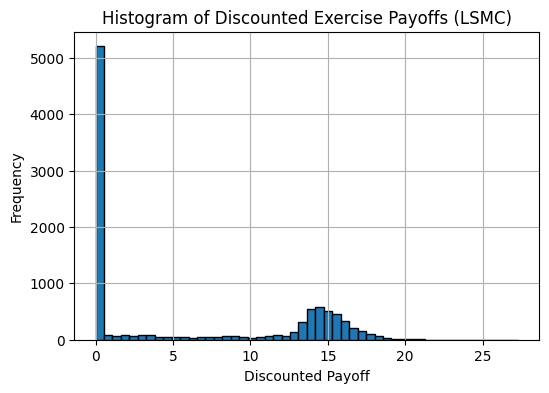

In [24]:
import matplotlib.pyplot as plt

def exercise_payoff_histogram(S, K, r, sigma, T, steps=50, n_paths=10000, option_type='put', seed=42):
    """
    Run LSMC, record the discounted payoff of each path, and histogram.
    """
    np.random.seed(seed)
    dt = T / steps
    discount = np.exp(-r*dt)
    
    S_paths = np.zeros((steps+1, n_paths))
    S_paths[0,:] = S
    for t in range(1, steps+1):
        Z = np.random.randn(n_paths)
        S_paths[t,:] = S_paths[t-1,:] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    
    if option_type.lower() == 'put':
        payoff = lambda x: np.maximum(K - x, 0)
    else:
        payoff = lambda x: np.maximum(x - K, 0)
    
    CF = np.zeros((steps+1, n_paths))
    CF[steps,:] = payoff(S_paths[steps,:])
    
    for t in range(steps-1, -1, -1):
        itm = payoff(S_paths[t,:]) > 0
        X = S_paths[t, itm]
        discounted_future = np.zeros(X.shape[0])
        for i, path_idx in enumerate(np.where(itm)[0]):
            future_ex_idx = np.where(CF[t+1:, path_idx] > 0)[0]
            if len(future_ex_idx) > 0:
                first_ex = future_ex_idx[0]
                discounted_future[i] = CF[t+1+first_ex, path_idx] * discount**(first_ex+1)
            else:
                discounted_future[i] = 0
        
        A = np.vstack([np.ones(X.shape[0]), X, X**2]).T
        coeff, _, _, _ = np.linalg.lstsq(A, discounted_future, rcond=None)
        
        continuation_value = coeff[0] + coeff[1]*X + coeff[2]*X**2
        exercise_value = payoff(X)
        exercise_idx = (exercise_value > continuation_value)
        
        exercise_paths = np.where(itm)[0][exercise_idx]
        CF[t, exercise_paths] = exercise_value[exercise_idx]
        for ep in exercise_paths:
            CF[t+1:, ep] = 0
    
    # gather discounted payoff
    discounted_payoffs = np.zeros(n_paths)
    for path_idx in range(n_paths):
        ex_times = np.where(CF[:, path_idx]>0)[0]
        if len(ex_times) > 0:
            first_ex = ex_times[0]
            discounted_payoffs[path_idx] = CF[first_ex, path_idx]*np.exp(-r*(first_ex*dt))

    plt.figure(figsize=(6,4))
    plt.hist(discounted_payoffs, bins=50, edgecolor='k')
    plt.title('Histogram of Discounted Exercise Payoffs (LSMC)')
    plt.xlabel('Discounted Payoff')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

exercise_payoff_histogram(S0, K, r, sigma, T=1.0, steps=50, n_paths=10000, option_type='put')


Interpretation: This histogram shows the distribution of realized (discounted) payoffs across the Monte Carlo paths under the optimal stopping policy discovered by LSMC.

---

## 9. Method comparison

We have seen multiple approaches for pricing European and American options. Let’s summarize some key points:

| Method                   | Model Assumptions                      | Pros                                                                 | Cons                                                                       | Runtime Complexity        | Ease of Greeks               |
| :----------------------- | :------------------------------------- | :------------------------------------------------------------------- | :------------------------------------------------------------------------- | :------------------------ | :--------------------------- |
| **Black–Scholes–Merton (BSM)** | GBM, no dividends, constant $\sigma$, frictionless | Closed-form for European options                                     | Only handles European style; many simplifying assumptions                    | $O(1)$ for evaluation     | Direct analytic Greeks       |
| **Monte Carlo (plain)**  | Flexible model dynamics               | Simple to implement; handles path-dependent, multi-dim.             | Convergence can be slow ($1/\sqrt{N}$); variance can be high; tricky for American | $O(M)$ for $M$ sims       | Greeks via finite-differencing (bumping) or AAD |
| **Binomial Tree**        | Discrete steps, risk-neutral prob.     | Intuitive; handles American style                                    | Large number of steps needed for accuracy; can be slower for high accuracy | $O(N^2)$ for $N$ steps    | Greeks by finite differences on tree or "greek lattices" |
| **Finite Difference**    | PDE approach (Crank–Nicolson, etc.)    | Accurate for wide class of PDEs; handles American style              | Implementation can be complex; must handle free boundary carefully        | $O(N_S \cdot N_t)$ $N_S$=space, $N_t$=time | Greeks from PDE solution grid |
| **LSMC**                 | Regression-based Monte Carlo           | Handles high-dimensional American/Bermudan options                   | Approximation error depends on basis choice, # paths, # steps; biased low   | $O(M \cdot N \cdot K)$ $M$=paths, $N$=steps, $K$=basis complexity | Greeks are more challenging (AAD, pathwise diff.) |

---

### 9.1 Benchmark on a single test case

Below is a rough timing comparison (in seconds) for each method on a standard parameter set ($S_0=100, K=100, r=5\%, \sigma=20\%, T=1$). We will run them with moderate discretization parameters (e.g., $N=100$ for steps/time, $M=10000$ for paths) and measure elapsed time using Python's `time` module.

*(Note: This is just a quick, illustrative comparison on one machine. Actual performance depends heavily on implementation details, hardware, specific parameters, required accuracy, and optimization techniques used. Results may vary significantly.)*

In [25]:
import time

# Common test parameters
S0_test = 100
K_test = 100
r_test = 0.05
sigma_test = 0.2
T_test = 1.0

# 1) Black-Scholes closed-form (European only)
start = time.time()
bs_call = black_scholes_price(S0_test, K_test, r_test, sigma_test, T_test, 'call')
bs_put  = black_scholes_price(S0_test, K_test, r_test, sigma_test, T_test, 'put')
time_bs = time.time() - start

# 2) MC (European, 100_000 paths)
start = time.time()
mc_call = euro_vanilla_mc(S0_test, K_test, r_test, sigma_test, T_test, n_sims=100_000, option_type='call')
mc_put  = euro_vanilla_mc(S0_test, K_test, r_test, sigma_test, T_test, n_sims=100_000, option_type='put')
time_mc = time.time() - start

# 3) Binomial (American, 500 steps)
start = time.time()
am_call_bin = american_binomial_price(S0_test, K_test, r_test, sigma_test, T_test, steps=500, option_type='call')
am_put_bin  = american_binomial_price(S0_test, K_test, r_test, sigma_test, T_test, steps=500, option_type='put')
time_bin = time.time() - start

# 4) Finite Difference (American Put, M=100, N=100)
start = time.time()
am_put_fd, _ = american_put_fd(S0_test, K_test, r_test, sigma_test, T_test, 
                               Smax=300, M=100, N=100)
time_fd = time.time() - start

# 5) LSMC (American Put, 50 steps, 10000 paths)
start = time.time()
am_put_lsmc = american_lsmc_price(S0_test, K_test, r_test, sigma_test, T_test,
                                  steps=50, n_paths=10000, option_type='put')
time_lsmc = time.time() - start

print("=== Benchmark Results ===")
print(f"BSM Call={bs_call:.4f}, Put={bs_put:.4f}, time={time_bs:.6f} seconds")
print(f"MC Call={mc_call:.4f},  Put={mc_put:.4f},  time={time_mc:.6f} seconds")
print(f"Binomial American Call={am_call_bin:.4f}, Put={am_put_bin:.4f}, time={time_bin:.6f} seconds")
print(f"FD American Put={am_put_fd:.4f},          time={time_fd:.6f} seconds")
print(f"LSMC American Put={am_put_lsmc:.4f},      time={time_lsmc:.6f} seconds")


=== Benchmark Results ===
BSM Call=10.4506, Put=5.5735, time=0.005816 seconds
MC Call=10.4739,  Put=5.5742,  time=0.042102 seconds
Binomial American Call=10.4466, Put=6.0888, time=1.067447 seconds
FD American Put=6.0997,          time=0.427252 seconds
LSMC American Put=6.0959,      time=0.919013 seconds


**Interpretation**:

-   The **BSM formula** is nearly instantaneous as it's a direct calculation.
-   The **Monte Carlo method** (for European options) scales with the number of paths; its runtime depends on the desired accuracy (more paths = longer time) but is often simple to parallelize.
-   The **Binomial approach** for American options is typically quite fast for a moderate number of steps ($N$), but its computational cost grows quadratically ($O(N^2)$), making high-accuracy runs slower.
-   The **Finite-difference approach** can be efficient and accurate, especially with optimized solvers like Crank-Nicolson + SOR/PSOR. Its complexity depends on the grid size ($O(N_S \cdot N_t)$), and implementation requires careful handling of the PDE discretization and boundary conditions.
-   The **LSMC approach** offers flexibility, particularly for high-dimensional problems where grid-based methods become infeasible (curse of dimensionality). However, its runtime depends on the number of paths, time steps, and the complexity of the regression ($O(M \cdot N \cdot K)$), and it might be slower than tree or FDM methods for simple, low-dimensional options. The choice of basis functions is also critical for accuracy.


## 10. Conclusion

In this lesson, we covered:

-   The conceptual foundations of options (payoffs, European vs. American).
-   The derivation and use of the Black–Scholes–Merton formula for European options.
-   Monte Carlo simulation under the risk-neutral measure for European options.
-   Key numerical methods for American option pricing, addressing the early exercise feature:
    -   **Binomial trees**: A discrete-time approximation that converges to BSM for European options and handles American options intuitively.
    -   **Finite-difference PDE methods**: Solving the underlying partial differential equation numerically, treating early exercise as a free-boundary problem.
    -   **Least-Squares Monte Carlo (LSMC)**: A simulation-based approach that learns the optimal stopping (exercise) rule via regression on simulated paths.

These methods illustrate the spectrum from:
-   **Closed-form solutions** (like BSM): Fast and exact under specific assumptions, but limited in scope (typically European, simple underlying dynamics).
-   **Simulation methods** (like Monte Carlo): Highly flexible for complex payoffs, underlying processes, and multiple dimensions, but can be computationally intensive and less straightforward for American options (requiring techniques like LSMC).
-   **Numerical methods for PDEs/trees**: Handle early exercise explicitly but involve discretization choices and can be complex to implement and computationally demanding for high accuracy or dimensions.

**Real-world extensions** to keep in mind that often necessitate moving beyond the basic models:

-   **Dividends**: Need to be incorporated into the models, either as a continuous yield (modifying the drift $r \to r-q$) or by adjusting the stock price for discrete dividend payments, especially relevant for American option pricing.
-   **Stochastic Volatility**: Models like Heston or SABR acknowledge that volatility is not constant, better matching market smiles/skews, but require more advanced numerical schemes (often MC or PDE).
-   **Early Exercise for Calls**: While typically not optimal for American calls on non-dividend stocks, early exercise *can* be optimal for calls on dividend-paying stocks, usually just before an ex-dividend date.
-   **Stochastic Interest Rates**: Models incorporating non-constant interest rates exist but add complexity.
-   **Exotic Payoffs**: Options with features like barriers, lookbacks, or Asian averaging often require tailored PDE solvers or Monte Carlo simulation, as closed-form solutions are rare.